# Preparation

## Import Library

In [72]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=22dde78358404987923518bda6c9f3f7f4e06b786093672ef1c768a39b6eb5c7
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import time
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
import pickle
import zipfile
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd

## Load Data

In [4]:
zip_path = "/content/drive/MyDrive/Datasets/stanford_car_dataset_by_classes.zip"
extract_path = "/content/Dataset"

# สร้างโฟลเดอร์ถ้ายังไม่มี
os.makedirs(extract_path, exist_ok=True)

# แตกไฟล์
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
DATASET_DIR = "/content/Dataset"

TEST_DIR = os.path.join(DATASET_DIR, "car_data", "car_data", "test")

In [16]:
SIZE_RESNET = 448
SIZE_EFFNET = 380
BATCH_SIZE = 16

temp_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=(SIZE_RESNET, SIZE_RESNET), batch_size=1, shuffle=False
)
class_names = temp_ds.class_names
print(f"Loaded {len(class_names)} class names.")

# ฟังก์ชันโหลดและเตรียมรูป (สำหรับ Upload)
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    return img_expanded, img

Found 8041 files belonging to 196 classes.
Loaded 196 class names.


## Load Model

In [8]:
resnet_path = '/content/drive/MyDrive/Model/FinalResnet_Final/models/resnet50_final_final_final.keras'
effnet_path = '/content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras'

resnet_model = tf.keras.models.load_model(resnet_path)

effnet_model = tf.keras.models.load_model(effnet_path)

print("Both Models Loaded Successfully!")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 222 variables whereas the saved optimizer has 226 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Both Models Loaded Successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 842 variables whereas the saved optimizer has 846 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Feature Extractor Setup

In [9]:
print("Building Feature Extractor from EfficientNetB4...")
feature_extractor = tf.keras.Model(
    inputs=effnet_model.input,
    outputs=effnet_model.layers[-2].output
)

Building Feature Extractor from EfficientNetB4...


## Building Similarity Database

### ไม่จำเป็นต้องรัน (สำหรับสร้าง database)

In [10]:
SAVE_PATH = '/content/drive/MyDrive/Model/car_database.pkl' # เซฟลง Drive
IMG_SIZE_EFFNET = 380

# --- Load Model & Feature Extractor ---
effnet_path = '/content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras'
model = tf.keras.models.load_model(effnet_path)

# ตัดหัวเอาแค่ Feature Vector
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)

def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    return img_expanded

# --- Loop สร้างฐานข้อมูล (Full Test Set) ---
print("Building Full Database (This may take 10-20 mins)...")
db_features = []
db_paths = []
db_labels = []

count = 0
for root, dirs, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            label_name = os.path.basename(root)

            try:
                # 1. เตรียมรูป
                img_tensor = load_and_preprocess_image(img_path, IMG_SIZE_EFFNET)
                # 2. ดึง Feature
                feat = feature_extractor.predict(img_tensor, verbose=0)

                # 3. เก็บข้อมูล
                db_features.append(feat[0])
                db_paths.append(img_path)
                db_labels.append(label_name)

                count += 1
                if count % 100 == 0: print(f"Processed {count} images...")
            except Exception as e:
                print(f"Error processing {file}: {e}")

# --- Save ลงไฟล์ ---
print(f"Saving database to {SAVE_PATH}...")
with open(SAVE_PATH, 'wb') as f:
    pickle.dump({
        'features': np.array(db_features),
        'paths': db_paths,
        'labels': db_labels
    }, f)

Building Full Database (This may take 10-20 mins)...
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
Processed 1400 images...
Processed 1500 images...
Processed 1600 images...
Processed 1700 images...
Processed 1800 images...
Processed 1900 images...
Processed 2000 images...
Processed 2100 images...
Processed 2200 images...
Processed 2300 images...
Processed 2400 images...
Processed 2500 images...
Processed 2600 images...
Processed 2700 images...
Processed 2800 images...
Processed 2900 images...
Processed 3000 images...
Processed 3100 images...
Processed 3200 images...
Processed 3300 images...
Processed 3400 images...
Processed 3500 images...
Processed 3600 images...
Processed 3700 images...
Processed 3800 images...
Proces

## Load Database

In [11]:
DB_PATH = '/content/drive/MyDrive/Model/car_database.pkl'

print(f"Loading Car Database from: {DB_PATH}")

if os.path.exists(DB_PATH):
    with open(DB_PATH, 'rb') as f:
        data = pickle.load(f)

    database_features = data['features']
    database_paths = data['paths']
    database_labels = data['labels']

    print(f"Database Loaded! Found {len(database_features)} cars ready for search.")
else:
    print("ไม่เจอไฟล์ฐานข้อมูล! กรุณารันโค้ดสร้างฐานข้อมูลก่อน")

Loading Car Database from: /content/drive/MyDrive/Model/car_database.pkl
Database Loaded! Found 8041 cars ready for search.


## Utility Function

In [12]:
def measure_inference_speed(model, img_tensor, iterations=10):
    # Warmup (รันเล่นๆ ก่อนเพื่อให้ GPU ตื่น)
    for _ in range(3):
        model.predict(img_tensor, verbose=0)

    # จับเวลาจริง
    start_time = time.time()
    for _ in range(iterations):
        model.predict(img_tensor, verbose=0)
    end_time = time.time()

    avg_time_ms = ((end_time - start_time) / iterations) * 1000
    return avg_time_ms

In [93]:
def make_gradcam_heatmap(img_tensor, full_model, backbone_name, conv_layer_name, pred_index=None):
    """
    Grad-CAM แบบ Manual Forward Pass (แก้ปัญหา KeyError/Graph Disconnect)
    1. แยกส่วน Backbone ออกมาเพื่อดึง Feature Map
    2. รันส่วน Head (Classifier) ทีละ Layer ด้วยมือ เพื่อเลี่ยงการสร้างโมเดลใหม่
    """

    # 1. ดึง Backbone (Inner Model) ออกมา
    try:
        backbone = full_model.get_layer(backbone_name)
    except ValueError:
        print(f"❌ Error: ไม่เจอ Backbone '{backbone_name}'")
        return np.zeros((img_tensor.shape[1], img_tensor.shape[2]))

    # 2. สร้างโมเดลเฉพาะส่วน Backbone ที่คายของออกมา 2 อย่าง:
    #    a) Conv Output (สำหรับ Heatmap)
    #    b) Backbone Output (สำหรับส่งต่อให้ Head)
    try:
        # พยายามหา Layer ข้างใน
        conv_output = backbone.get_layer(conv_layer_name).output
    except ValueError:
        print(f"⚠️ หา Layer '{conv_layer_name}' ไม่เจอใน {backbone_name}")
        return np.zeros((img_tensor.shape[1], img_tensor.shape[2]))

    backbone_multi_output = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=[conv_output, backbone.output]
    )

    # 3. ระบุ Layer ที่เป็นส่วนหัว (Head) คือ Layer ทั้งหมดที่อยู่ต่อจาก Backbone
    head_layers = []
    found_backbone = False
    for layer in full_model.layers:
        if layer.name == backbone_name:
            found_backbone = True
            continue # ข้ามตัว backbone ไป
        if found_backbone:
            head_layers.append(layer)

    # 4. 🧮 คำนวณ Gradients
    with tf.GradientTape() as tape:
        # 4.1 รันผ่าน Backbone
        conv_out, backbone_out = backbone_multi_output(img_tensor)

        # 4.2 สั่ง Tape ให้จับตาดู Conv Output ไว้
        tape.watch(conv_out)

        # 4.3 รันผ่าน Head ทีละ Layer (Manual Forward Pass)
        x = backbone_out
        for layer in head_layers:
            x = layer(x) # เรียกใช้ layer โดยตรง ไม่ต้อง build model ใหม่

        preds = x

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 5. คำนวณ Gradient และสร้าง Heatmap
    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ฟังก์ชันสำหรับซ้อน Heatmap ลงบนรูปจริง
from PIL import Image # ต้องใช้ PIL.Image สำหรับการ Resize แบบพิเศษ

def overlay_heatmap_sharper(heatmap, original_img_array, alpha=0.4, threshold=0.3, sharpness_mode='lanczos'):
    """
    สร้าง Heatmap แบบคมชัดขึ้น (Sharper Grad-CAM)
    - threshold (0.0 - 1.0): ตัดค่าที่ต่ำกว่านี้ทิ้งไปเลย (ช่วยลด noise)
    - sharpness_mode: 'lanczos' (คมแบบเนียน), 'nearest' (คมแบบ pixelated)
    """
    # 1. Thresholding: ตัด noise ทิ้ง เพื่อให้จุดโฟกัสเด่นขึ้น
    # (สร้าง copy เพื่อไม่ให้กระทบ array เดิม)
    heatmap_processed = heatmap.copy()
    heatmap_processed[heatmap_processed < threshold] = 0

    # Re-normalize หลังจากตัด threshold
    if np.max(heatmap_processed) > 0:
         heatmap_processed = heatmap_processed / np.max(heatmap_processed)

    # 2. แปลงเป็นสี (Colormap)
    heatmap_uint8 = np.uint8(255 * heatmap_processed)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]

    # 3. Resize แบบคมชัด (The Magic Step!)
    jet_heatmap_img = image.array_to_img(jet_heatmap)

    # เลือกโหมดการขยายภาพ
    if sharpness_mode == 'nearest':
        # แบบ Nearest Neighbor: คมกริบ เป็นบล็อกๆ เห็นชัดว่า original คือ 14x14
        resample_method = Image.NEAREST
    else:
        # แบบ Lanczos (Default): คมชัดแต่ยังมีความเนียน (แนะนำอันนี้)
        resample_method = Image.LANCZOS

    jet_heatmap_img = jet_heatmap_img.resize(
        (original_img_array.shape[1], original_img_array.shape[0]),
        resample=resample_method
    )
    jet_heatmap_final = image.img_to_array(jet_heatmap_img)

    # 4. ซ้อนภาพ
    superimposed_img = jet_heatmap_final * alpha + original_img_array
    superimposed_img = image.array_to_img(superimposed_img)
    return superimposed_img

In [81]:
# เช็ค ResNet
print("--- ResNet Layers ---")
for layer in resnet_model.layers:
    print(f"L1: {layer.name}")
    if hasattr(layer, 'layers'): # ถ้ามีไส้ใน
        for sub_layer in layer.layers[-5:]: # ดู 5 ตัวท้าย
            print(f"   L2: {sub_layer.name}")

--- ResNet Layers ---
L1: input_layer_1
L1: resnet50
   L2: conv5_block3_2_relu
   L2: conv5_block3_3_conv
   L2: conv5_block3_3_bn
   L2: conv5_block3_add
   L2: conv5_block3_out
L1: global_average_pooling2d
L1: batch_normalization
L1: dropout
L1: dense
L1: batch_normalization_1
L1: dropout_1
L1: dense_1


In [83]:
# เช็ค ResNet
print("--- EffNet Layers ---")
for layer in effnet_model.layers:
    print(f"L1: {layer.name}")
    if hasattr(layer, 'layers'): # ถ้ามีไส้ใน
        for sub_layer in layer.layers[-5:]: # ดู 5 ตัวท้าย
            print(f"   L2: {sub_layer.name}")

--- EffNet Layers ---
L1: input_layer_4
L1: data_augmentation
   L2: random_flip
   L2: random_rotation
   L2: random_zoom
   L2: random_contrast
   L2: random_translation
L1: efficientnetb4
   L2: block7b_drop
   L2: block7b_add
   L2: top_conv
   L2: top_bn
   L2: top_activation
L1: global_average_pooling2d_1
L1: batch_normalization_1
L1: dropout_1
L1: dense_1


# Demo

🚀 Upload an image to analyze...


Saving Bentley Continental Supersports Conv. Convertible 2012.webp to Bentley Continental Supersports Conv. Convertible 2012 (1).webp

Analyzing: Bentley Continental Supersports Conv. Convertible 2012 (1).webp ...
Generating Heatmaps...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 448, 448, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(1, 380, 380, 3))
  warnings.warn(msg)
/tmp/ipython-input-2690678815.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


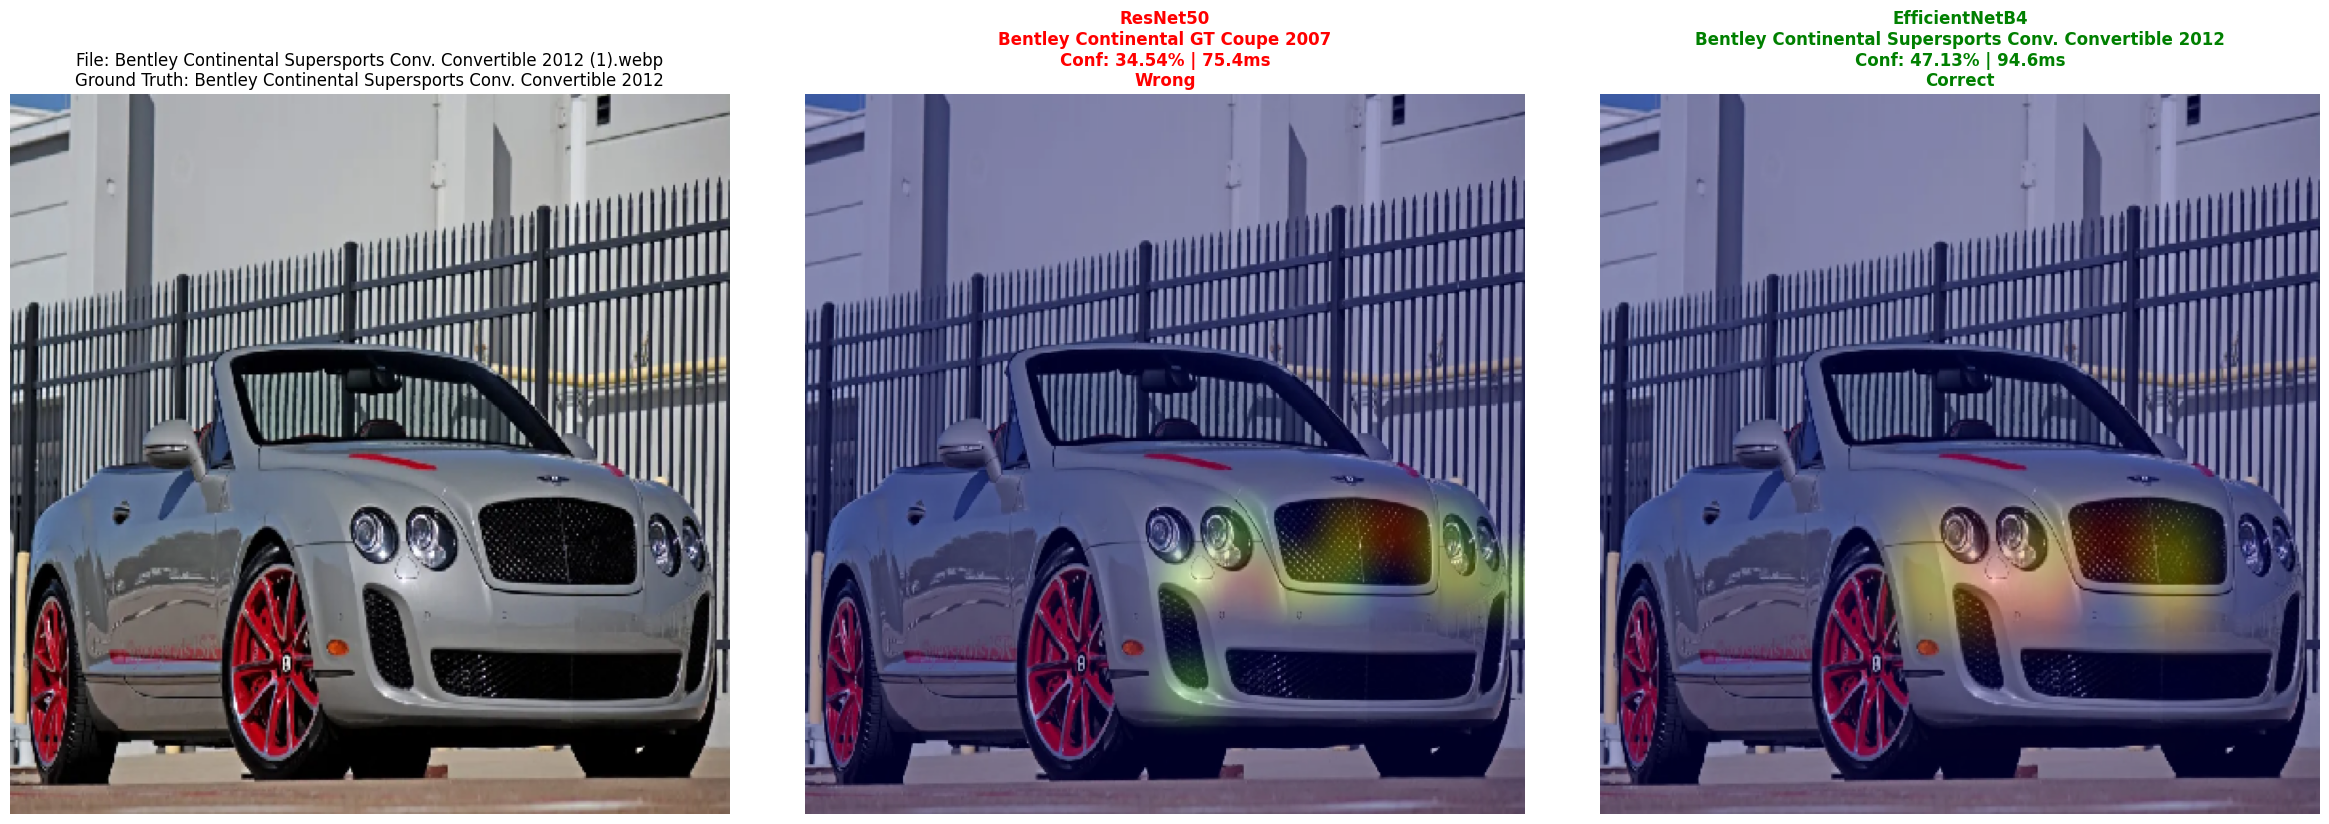

------------------------------------------------------------
📊 TOP 3 PREDICTIONS ANALYSIS
------------------------------------------------------------
Rank                                              ResNet Prediction                                              EffNet Prediction
 1st                      Bentley Continental GT Coupe 2007 (34.5%) Bentley Continental Supersports Conv. Convertible 2012 (47.1%)
 2nd Bentley Continental Supersports Conv. Convertible 2012 (30.6%)                       Bentley Continental GT Coupe 2007 (3.9%)
 3rd                      Bentley Continental GT Coupe 2012 (13.3%)                       Bentley Continental GT Coupe 2012 (3.3%)
------------------------------------------------------------

🔎 Finding visually similar cars (Database Search)...


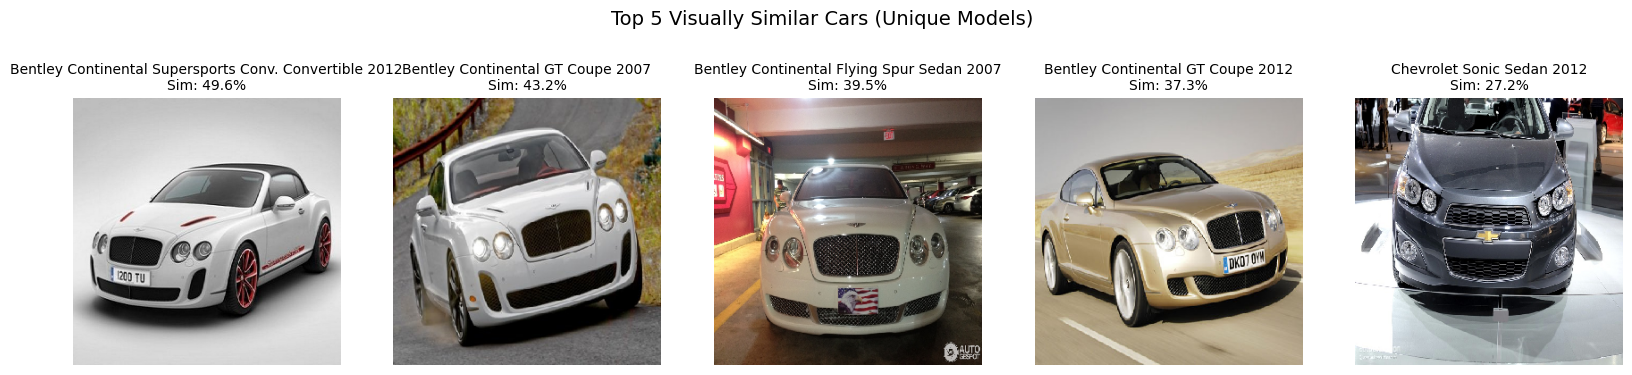

In [122]:
from google.colab import files

# ==========================================
# 🔧 CONFIG
# ==========================================
RESNET_BACKBONE = 'resnet50'
RESNET_INNER = 'conv5_block3_out'
EFFNET_BACKBONE = 'efficientnetb4'
EFFNET_INNER = 'top_activation'
THRESHOLD = 0.5 # ปรับความคมของ Heatmap
# ==========================================

print("🚀 Upload an image to analyze...")
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    print(f"\nAnalyzing: {fn} ...")

    # --- 1. Prepare Images ---
    img_448, orig_448 = load_and_preprocess_image(img_path, SIZE_RESNET)
    img_380, orig_380 = load_and_preprocess_image(img_path, SIZE_EFFNET)

    # --- 2. Predictions & Speed ---
    # ResNet
    speed_res = measure_inference_speed(resnet_model, img_448, iterations=3)
    pred_res_raw = resnet_model.predict(img_448, verbose=0)
    idx_res = np.argmax(pred_res_raw)
    conf_res = np.max(pred_res_raw) * 100
    res_name = class_names[idx_res]
    # (Get Top 3 ResNet)
    top3_idx_res = pred_res_raw[0].argsort()[-3:][::-1]
    top3_res = [(class_names[i], pred_res_raw[0][i]*100) for i in top3_idx_res]

    # EffNet
    speed_eff = measure_inference_speed(effnet_model, img_380, iterations=3)
    pred_eff_raw = effnet_model.predict(img_380, verbose=0)
    idx_eff = np.argmax(pred_eff_raw)
    conf_eff = np.max(pred_eff_raw) * 100
    eff_name = class_names[idx_eff]
    # (Get Top 3 EffNet)
    top3_idx_eff = pred_eff_raw[0].argsort()[-3:][::-1]
    top3_eff = [(class_names[i], pred_eff_raw[0][i]*100) for i in top3_idx_eff]

    # --- 3. Check Ground Truth ---
    real_label = None
    for name in class_names:
        if name.lower().replace(" ", "") in fn.lower().replace(" ", ""):
            real_label = name
            break

    # Set Status Text/Color
    if real_label:
        col_res = 'green' if res_name == real_label else 'red'
        status_res = "Correct" if res_name == real_label else f"Wrong"

        col_eff = 'green' if eff_name == real_label else 'red'
        status_eff = "Correct" if eff_name == real_label else f"Wrong"

        truth_text = f"Ground Truth: {real_label}"
    else:
        col_res = 'black'; status_res = ""
        col_eff = 'black'; status_eff = ""
        truth_text = "Ground Truth: Unknown (Filename doesn't match)"

    # --- 4. Heatmaps (Manual Forward Pass - Robust) ---
    print("Generating Heatmaps...")
    hm_res = make_gradcam_heatmap(img_448, resnet_model, RESNET_BACKBONE, RESNET_INNER, idx_res)
    hm_eff = make_gradcam_heatmap(img_380, effnet_model, EFFNET_BACKBONE, EFFNET_INNER, idx_eff)

    vis_res = overlay_heatmap_sharper(hm_res, image.img_to_array(orig_448), threshold=THRESHOLD, sharpness_mode='lanczos')
    vis_eff = overlay_heatmap_sharper(hm_eff, image.img_to_array(orig_380), threshold=THRESHOLD, sharpness_mode='lanczos')

    # --- 5. Visualization ---
    plt.figure(figsize=(24, 8))

    # Plot 1: Original
    plt.subplot(1, 3, 1)
    plt.imshow(orig_380)
    plt.title(f"File: {fn}\n{truth_text}", fontsize=12)
    plt.axis('off')

    # Plot 2: ResNet
    plt.subplot(1, 3, 2)
    plt.imshow(vis_res)
    title_res = f"ResNet50\n{res_name}\nConf: {conf_res:.2f}% | {speed_res:.1f}ms"
    if status_res: title_res += f"\n{status_res}"
    plt.title(title_res, color=col_res, fontweight='bold', fontsize=12)
    plt.axis('off')
    # Show Top 3 as text in graph (optional) or just rely on print below
    plt.xlabel(f"Top 3:\n1. {top3_res[0][0]}\n2. {top3_res[1][0]}\n3. {top3_res[2][0]}", fontsize=10)

    # Plot 3: EffNet
    plt.subplot(1, 3, 3)
    plt.imshow(vis_eff)
    title_eff = f"EfficientNetB4\n{eff_name}\nConf: {conf_eff:.2f}% | {speed_eff:.1f}ms"
    if status_eff: title_eff += f"\n{status_eff}"
    plt.title(title_eff, color=col_eff, fontweight='bold', fontsize=12)
    plt.axis('off')
    plt.xlabel(f"Top 3:\n1. {top3_eff[0][0]}\n2. {top3_eff[1][0]}\n3. {top3_eff[2][0]}", fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- Print Text Summary (อ่านง่ายๆ) ---
    print("-" * 60)
    print(f"📊 TOP 3 PREDICTIONS ANALYSIS")
    print("-" * 60)

    # สร้าง DataFrame โชว์เทียบกันชัดๆ
    df_compare = pd.DataFrame({
        'Rank': ['1st', '2nd', '3rd'],
        'ResNet Prediction': [f"{n} ({p:.1f}%)" for n, p in top3_res],
        'EffNet Prediction': [f"{n} ({p:.1f}%)" for n, p in top3_eff]
    })
    print(df_compare.to_string(index=False))
    print("-" * 60)

    # --- 6. Similarity Search ---
    print("\n🔎 Finding visually similar cars (Database Search)...")
    if 'feature_extractor' not in globals():
         eff_inner = effnet_model.get_layer('efficientnetb4')
         feature_extractor = tf.keras.Model(inputs=eff_inner.inputs, outputs=eff_inner.output)

    curr_feat = feature_extractor.predict(img_380, verbose=0)
    sims = cosine_similarity(curr_feat, database_features)
    sorted_indices = sims[0].argsort()[::-1] # เรียงจากมากไปน้อยทั้งหมดมาก่อน

    # --- 🛠️ Logic ใหม่: หา 5 อันดับที่ไม่ซ้ำรุ่นกัน ---
    top_unique_indices = []
    seen_labels = set()

    # วนลูปหาจนกว่าจะครบ 5 คัน
    for idx in sorted_indices:
        label = database_labels[idx]

        # ถ้าเจอรุ่นนี้ไปแล้ว ให้ข้าม (จะได้ไม่ซ้ำ)
        if label in seen_labels:
            continue

        # ถ้ายังไม่เคยเจอ ให้เก็บไว้
        seen_labels.add(label)
        top_unique_indices.append(idx)

        # ครบ 5 คันแล้วหยุด
        if len(top_unique_indices) >= 5:
            break

    # เปลี่ยนตัวแปรให้ Loop ข้างล่างเอาไปใช้ต่อได้
    top_indices = top_unique_indices

    plt.figure(figsize=(20, 4))
    plt.suptitle(f"Top 5 Visually Similar Cars (Unique Models)", y=1.05, fontsize=14)

    for i, idx in enumerate(top_indices):
        path = database_paths[idx]
        label = database_labels[idx]
        score = sims[0][idx] * 100
        try:
            sim_img = image.load_img(path, target_size=(300, 300))
            plt.subplot(1, 5, i+1)
            plt.imshow(sim_img)
            plt.title(f"{label}\nSim: {score:.1f}%", fontsize=10)
            plt.axis('off')
        except: pass
    plt.show()

## สำรอง


🔎 Finding visually similar cars (Database Search)...


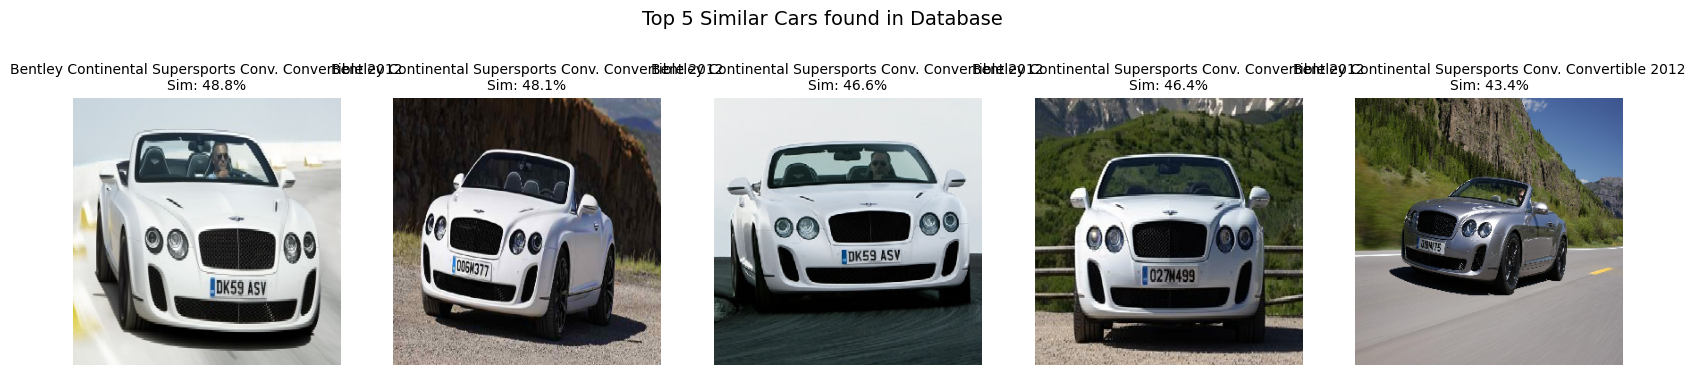

In [121]:
print("\n🔎 Finding visually similar cars (Database Search)...")
if 'feature_extractor' not in globals():
      eff_inner = effnet_model.get_layer('efficientnetb4')
      feature_extractor = tf.keras.Model(inputs=eff_inner.inputs, outputs=eff_inner.output)

curr_feat = feature_extractor.predict(img_380, verbose=0)
sims = cosine_similarity(curr_feat, database_features)
top_idxs = sims[0].argsort()[-6:-1][::-1]

plt.figure(figsize=(20, 4))
plt.suptitle(f"Top 5 Similar Cars found in Database", y=1.05, fontsize=14)

for i, idx in enumerate(top_idxs):
    path = database_paths[idx]
    label = database_labels[idx]
    score = sims[0][idx] * 100
    try:
        sim_img = image.load_img(path, target_size=(300, 300))
        plt.subplot(1, 5, i+1)
        plt.imshow(sim_img)
        plt.title(f"{label}\nSim: {score:.1f}%", fontsize=10)
        plt.axis('off')
    except: pass
plt.show()

In [119]:
# พิมพ์ชื่อคลาสทั้งหมดออกมาดู
print("รายชื่อคลาสที่ระบบรู้จัก (Copy ไปตั้งชื่อไฟล์ได้เลย):")
for name in class_names[:50]: # ดู 20 ชื่อแรกเป็นตัวอย่าง
    print(name)

รายชื่อคลาสที่ระบบรู้จัก (Copy ไปตั้งชื่อไฟล์ได้เลย):
AM General Hummer SUV 2000
Acura Integra Type R 2001
Acura RL Sedan 2012
Acura TL Sedan 2012
Acura TL Type-S 2008
Acura TSX Sedan 2012
Acura ZDX Hatchback 2012
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Coupe 2012
Aston Martin Virage Convertible 2012
Aston Martin Virage Coupe 2012
Audi 100 Sedan 1994
Audi 100 Wagon 1994
Audi A5 Coupe 2012
Audi R8 Coupe 2012
Audi RS 4 Convertible 2008
Audi S4 Sedan 2007
Audi S4 Sedan 2012
Audi S5 Convertible 2012
Audi S5 Coupe 2012
Audi S6 Sedan 2011
Audi TT Hatchback 2011
Audi TT RS Coupe 2012
Audi TTS Coupe 2012
Audi V8 Sedan 1994
BMW 1 Series Convertible 2012
BMW 1 Series Coupe 2012
BMW 3 Series Sedan 2012
BMW 3 Series Wagon 2012
BMW 6 Series Convertible 2007
BMW ActiveHybrid 5 Sedan 2012
BMW M3 Coupe 2012
BMW M5 Sedan 2010
BMW M6 Convertible 2010
BMW X3 SUV 2012
BMW X5 SUV 2007
BMW X6 SUV 2012
BMW Z4 Convertible 2012
Bentley Arnage Sedan 2009
Bentley Continental Flying Spur 